In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [6]:
#helps me see what im working with
data = engine.execute("SELECT * FROM sqlite_master;")

for record in data:
    print(record)

('table', 'measurement', 'measurement', 2, 'CREATE TABLE measurement (\n\tid INTEGER NOT NULL, \n\tstation TEXT, \n\tdate TEXT, \n\tprcp FLOAT, \n\ttobs FLOAT, \n\tPRIMARY KEY (id)\n)')
('table', 'station', 'station', 3, 'CREATE TABLE station (\n\tid INTEGER NOT NULL, \n\tstation TEXT, \n\tname TEXT, \n\tlatitude FLOAT, \n\tlongitude FLOAT, \n\televation FLOAT, \n\tPRIMARY KEY (id)\n)')


In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
newest_date = session.query(Measurement).order_by(desc('date')).first()

# for n_date in newest_date:
#     print(n_date)
    
print(newest_date.date)
old_date = newest_date.date

2017-08-23


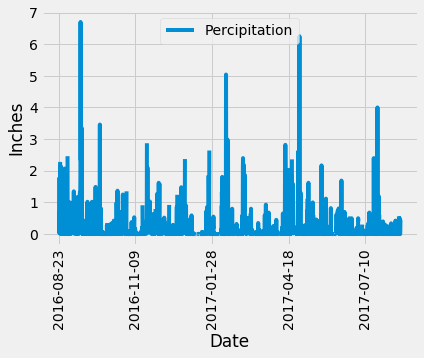

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
from datetime import datetime
from dateutil.relativedelta import relativedelta

#subtracts a year off of old_date variable
your_date_string = old_date
format_string = "%Y-%m-%d"

datetime_object = datetime.strptime(old_date, format_string).date()
new_date = datetime_object - relativedelta(years=1)
new_date_string = datetime.strftime(new_date, format_string).replace(' 0', ' ')

# Perform a query to retrieve the data and precipitation scores
sel=[Measurement.date, Measurement.prcp]
date_precip_scores = session.query(*sel).filter(Measurement.date >= new_date_string).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
date_precip_scores_pd = pd.DataFrame(date_precip_scores,columns=['Date', 'Precip_score'])




# Sort the dataframe by date (already done in the query)

# Use Pandas Plotting with Matplotlib to plot the data

date_precip_scores_pd.sort_values('Date', inplace=True)
date_precip_scores_pd.plot(x = 'Date', y='Precip_score', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(['Percipitation'])
plt.locator_params(axis="x", nbins=10)
plt.xticks(rotation = 90)
plt.show()





In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_precip_scores_pd['Precip_score'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precip_score, dtype: float64

# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number stations in the dataset
 
tot_stations = session.query(Station.station).count()


tot_stations


9

In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

sel2=[Measurement.station, func.count(Measurement.station).label("active")]
active_stations = session.query(*sel2).group_by(Measurement.station).order_by(desc("active")).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel3=[Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
date_precip_scores = session.query(*sel3).filter(Measurement.station >= active_stations[0][0]).all()

date_precip_scores



[('USC00519397', 54.0, 87.0, 73.56913655848132)]

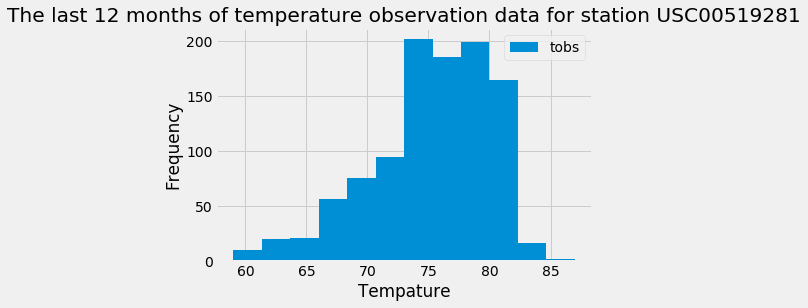

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel4=[Measurement.date, Measurement.tobs]
active_sation_histo = session.query(*sel4).filter(Measurement.date >= new_date_string).filter(Measurement.station >= active_stations[0][0]).all()

active_sation_histo_pd = pd.DataFrame(active_sation_histo,columns=['Date', 'tempatures'])

plt.hist(active_sation_histo_pd["tempatures"], bins = 12)
plt.xlabel("Tempature")
plt.ylabel("Frequency")
plt.legend(['tobs'])
plt.title(f"The last 12 months of temperature observation data for station {active_stations[0][0]}")
plt.show()


# Close session

In [32]:
# Close Session
session.close()

In [33]:
#Used for a visual when referencing database

df = pd.read_sql("SELECT * FROM measurement;", conn)

df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
